<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v4: Weight visualisation during learning
This is a new attempt at visualising weight changes during learning, now that I have a better understanding of TensorFlow's auto-graph.

Focus of this notebook:
* generating heatmap images of gradients over time of learning.

Sample training domains:

---


* Deep Learning Specialization C2W2A1 experiments with weight initialisation, against a simple 2D binary classification problem.

In [128]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit

## Useful tools

In [129]:
def plot_fit(history = None):
  pnum = 1

  plt.figure(layout='constrained')
  if history != None:
    plt.subplot(1,pnum,1)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')
  plt.show()

class LessVerboseEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, display_interval=None, display_total=10):
        super(LessVerboseEpochLogger, self).__init__()
        self.display_interval = display_interval
        self.display_total = display_total

    def set_params(self, params):
        self.epoch_count = params['epochs']
        if self.display_interval == None:
          self.display_interval = math.floor(self.epoch_count / self.display_total)

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch + 1) % self.display_interval == 0) or epoch == self.epoch_count-1:
            print(f'Epoch {epoch + 1:5d}:', end=' ')
            for key, value in logs.items():
                print(f'{key}: {value:.4f}', end='  ')
            print()

# some unit test utils
def test_equals(expected, actual):
  assert np.shape(actual) == np.shape(expected), f"Expected {expected} with shape {np.shape(expected)}, got: {actual} with shape {np.shape(actual)}"
  assert np.all(np.asarray(actual) == np.asarray(expected)), f"Expected {expected}, got: {actual}"

def test_raises(exception_type, func):
    res = None
    try:
      res = func()
    except Exception as e:
      res = e

    if isinstance(res, Exception):
      assert isinstance(res, exception_type), f"Expected {exception_type.__name__} but {type(e).__name__} was raised: {e}"
    else:
      assert False, f"Expected {exception_type.__name__} but returned without exception: {res}"

## Baseline: Simple model without visualisations
Actually, we're going to create a setup with few slightly different training regimes corresponding to the experiments from the coursework.


In [130]:
def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(10, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


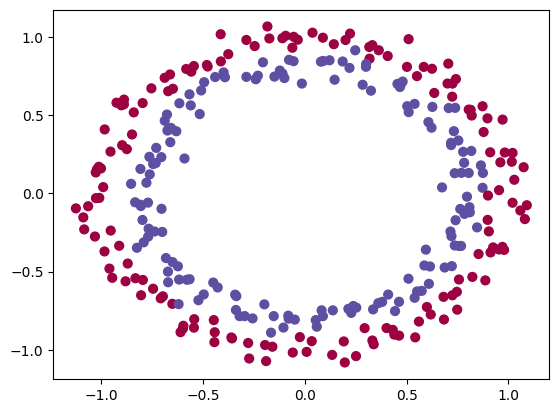

In [131]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [132]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=15000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch  1500: loss: 0.0785  
Epoch  3000: loss: 0.0227  
Epoch  4500: loss: 0.0122  
Epoch  6000: loss: 0.0086  
Epoch  7500: loss: 0.0071  
Epoch  9000: loss: 0.0065  
Epoch 10500: loss: 0.0063  
Epoch 12000: loss: 0.0062  
Epoch 13500: loss: 0.0062  
Epoch 15000: loss: 0.0061  
Total training time: 84.01 secs


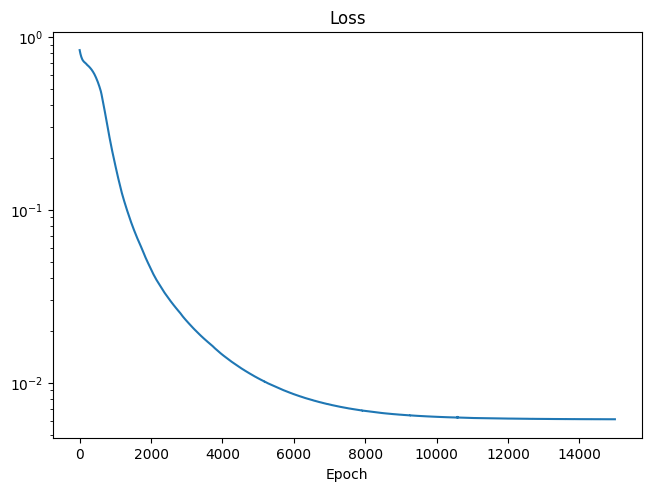

In [133]:
plot_fit(history)

## Quick Win: Weight Histogram
Let's create quick'n'dirty function for visualising the current weights, in the form of a histogram.

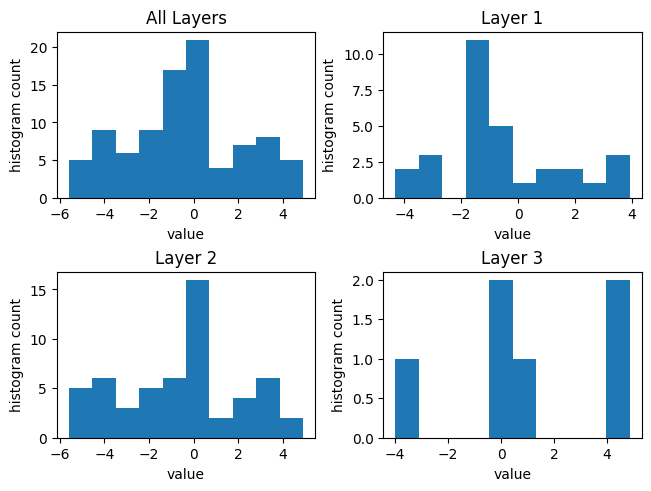

In [134]:
def plot_weights(model):
  """
  model - the model
  """

  # collect all variables across the entire model into a single flattened array
  all_variables = []
  for layer in model.layers:
    for weight in layer.weights:
      all_variables = np.append(all_variables, weight.numpy().flatten())

  L = len(model.layers)
  plots_tot = L+1
  plots_cols = math.floor(math.sqrt(plots_tot))
  plots_rows = math.ceil(plots_tot / plots_cols)

  plt.figure(layout='constrained')

  plt.subplot(plots_rows, plots_cols, 1)
  plt.title("All Layers")
  plt.hist(all_variables)
  plt.xlabel("value")
  plt.ylabel("histogram count")

  for l in range(L):
    variables = []
    for weight in model.layers[l].weights:
      variables = np.append(variables, weight.numpy().flatten())
    plt.subplot(plots_rows, plots_cols, l+2)
    plt.title(f"Layer {l+1}")
    plt.hist(variables)
    plt.xlabel("value")
    plt.ylabel("histogram count")
  plt.show()
plot_weights(model)

## Gradient heatmap
There's two things to do here:
1. Collect gradient information during training
2. Plot it in various ways.

TensorFlow doesn't seem to provide very good means for capturing gradient information during training. It's standard Logger interface doesn't get passed that information. Instead, an Optimizer-wrapper seems the only solution.

Furthermore, while using a `tf.TensorArray` seems like a sensible option, it seems to be optimized for use _within_ a `@tf.function` and can't be initialised outside like a `tf.Variable`. So I've so found the only solution is to store everything as a matrix inside a `tf.Variable`, with rows containing a flattened copy of all the necessary information, and successive rows representing successive iterations. This particular implementation adds a bit of a delay to execution time. The problem is that it doesn't know the total number of iterations up front, so we'll get a lot of re-allocation cost. I suspect a better approach is to combine a Callback with the optimizer wrapper, because the Callback gets enough information to pre-allocate the memory.

In [135]:
# Note the basic delegation implementation of optimizer was provided by ChatGPT and seems to be working
class LoggingOptimizerWrapper(tf.keras.optimizers.Optimizer):
  def __init__(self, optimizer='adam', name="LoggingOptimizerWrapper", **kwargs):
    """
    Args:
      delegate: real optimizer to wrap. String (name of optimizer) or optimizer instance. See `tf.keras.optimizers`.
    """
    if isinstance(optimizer, str):
      optimizer = tf.keras.optimizers.get(optimizer)
    super(LoggingOptimizerWrapper, self).__init__(f"{name}:{optimizer.name}", **kwargs)
    self._delegate = optimizer

    # the shape=None thing here tells the Variable to accept changing shapes
    # but it has the sideeffect that self._gradients_by_step.shape always returns None while executing.
    self._gradients_by_step = tf.Variable(np.zeros((0,0)), shape=tf.TensorShape(None), dtype=tf.float32)
    self._initialised = tf.Variable(0)

  def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
    """
      Args:
        grads_and_vars: List of `(gradient, variable)` pairs.
    """
    grads_and_vars = list(grads_and_vars)
    grads, _ = zip(*grads_and_vars)

    # concatenate all gradient tuples into a single vector
    flattened_grads = tf.zeros(shape=(1,0))
    for grad in grads:
      flattened_grads = tf.concat([flattened_grads, tf.reshape(grad, [1, -1])], axis=1)

    # append to list (or just set list on first iteration)
    tf.cond(self._initialised < 1,
            lambda: self._gradients_by_step.assign(flattened_grads),
            lambda: self._gradients_by_step.assign(tf.concat([self._gradients_by_step, flattened_grads], axis=0)))
    self._initialised.assign(1)

    # delegate for default behaviour
    return self._delegate.apply_gradients(grads_and_vars, name, experimental_aggregate_gradients)

  # delegate all other methods and properties

  def build(self, var_list):
    super().build(var_list)

  def _create_slots(self, var_list):
    self._delegate._create_slots(var_list)

  def _create_hypers(self):
    self._delegate._create_hypers()

  def _prepare_local(self, var_device, var_dtype, apply_state):
    return self._delegate._prepare_local(var_device, var_dtype, apply_state)

  def _resource_apply_dense(self, grad, var, apply_state=None):
    return self._delegate._resource_apply_dense(grad, var, apply_state)

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    return self._delegate._resource_apply_sparse(grad, var, indices, apply_state)

  def get_config(self):
    base_config = super(LoggingOptimizerWrapper, self).get_config()
    return {**base_config, "_delegate": tf.keras.optimizers.serialize(self._delegate)}

  @classmethod
  def from_config(cls, config, custom_objects=None):
    delegate_config = config.pop('_delegate')
    delegate = tf.keras.optimizers.deserialize(delegate_config, custom_objects=custom_objects)
    return cls(delegate, **config)

  def _serialize_hyperparameter(self, hyperparameter):
    return self._delegate._serialize_hyperparameter(hyperparameter)

  def get_updates(self, loss, params):
    return self._delegate.get_updates(loss, params)

  def get_weights(self):
    return self._delegate.get_weights()

  def set_weights(self, weights):
    self._delegate.set_weights(weights)

  def variables(self):
    return self._delegate.variables()

  def get_slot(self, var, name):
    return self._delegate.get_slot(var, name)

  def get_slot_names(self):
    return self._delegate.get_slot_names()

model = binary_classification_model('he_normal')
#model.compile(optimizer=LoggingOptimizerWrapper(tf.keras.optimizers.Adam()), loss='binary_crossentropy')
loggingOptimizer = LoggingOptimizerWrapper()
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=4, batch_size=train_X.shape[0])
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")

Epoch 1/4
1/1 [==============================] - 2s 2s/step - loss: 0.7069
Epoch 2/4
1/1 [==============================] - 0s 14ms/step - loss: 0.7064
Epoch 3/4
1/1 [==============================] - 0s 22ms/step - loss: 0.7060
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.7056
gradient_history: (4, 91)


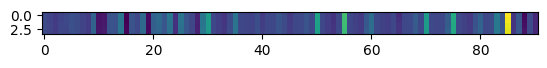

In [136]:
plt.imshow(gradient_history)

In [137]:
start = tf.timestamp()
model = binary_classification_model('he_normal')
loggingOptimizer = LoggingOptimizerWrapper()
model.compile(optimizer=loggingOptimizer, loss='binary_crossentropy')
history = model.fit(train_X, train_Y, epochs=5000, batch_size=train_X.shape[0], verbose=0, callbacks=[LessVerboseEpochLogger()])
duration = tf.timestamp() - start
gradient_history = loggingOptimizer._gradients_by_step.numpy()
print(f"gradient_history: {gradient_history.shape}")
print(f"Total training time: {duration.numpy():.2f} secs")

Epoch   500: loss: 0.3958  
Epoch  1000: loss: 0.1232  
Epoch  1500: loss: 0.0669  
Epoch  2000: loss: 0.0443  
Epoch  2500: loss: 0.0339  
Epoch  3000: loss: 0.0275  
Epoch  3500: loss: 0.0230  
Epoch  4000: loss: 0.0195  
Epoch  4500: loss: 0.0167  
Epoch  5000: loss: 0.0144  
gradient_history: (5000, 91)
Total training time: 32.87 secs


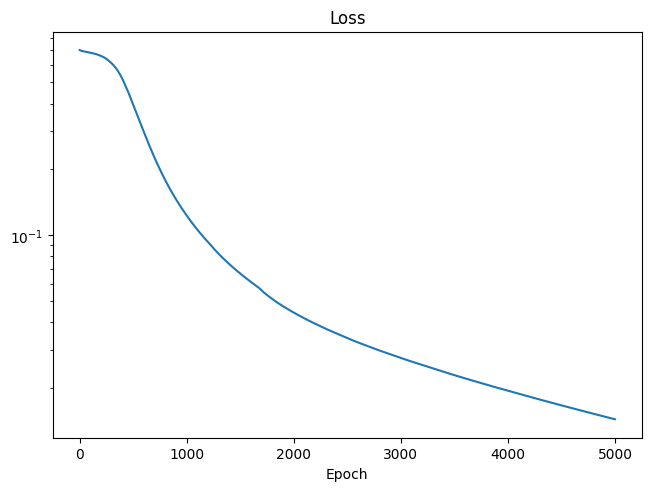

In [138]:
plot_fit(history)

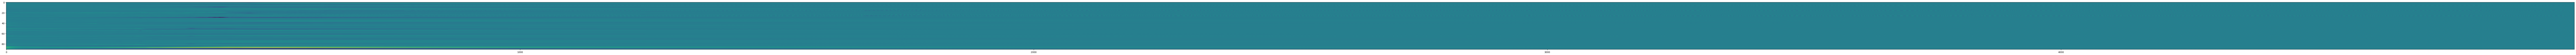

In [139]:
 plt.figure(figsize = (200,500))
plt.imshow(gradient_history.T)

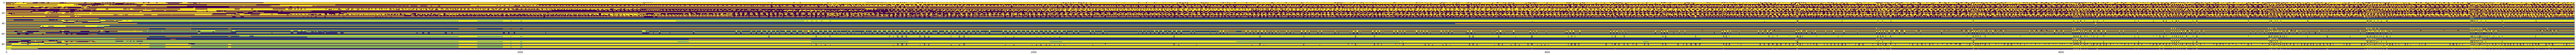

In [140]:
plt.figure(figsize = (200,500))
plt.imshow(np.sign(gradient_history.T))

In [141]:
gradient_history.shape

(5000, 91)

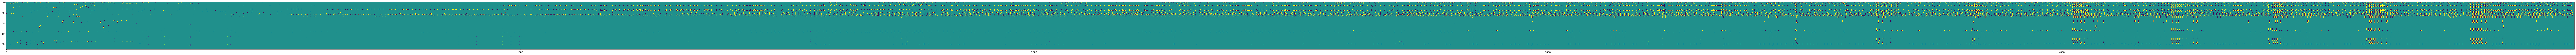

In [142]:
plt.figure(figsize = (200,500))
plt.imshow((np.sign(gradient_history[2:5000,:]) - np.sign(gradient_history[1:4999,:])).T)

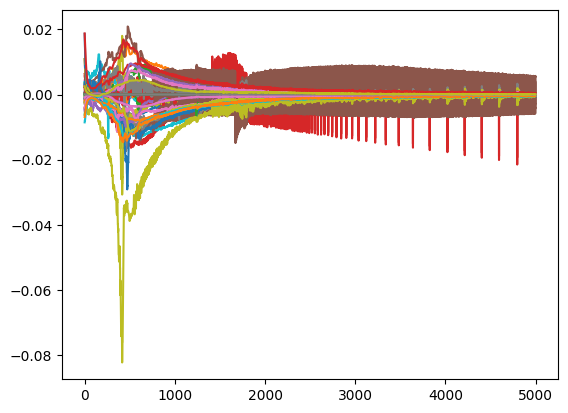

In [143]:
plt.plot(gradient_history[:,1:50])
plt.show()

## Filtering gradient information
Turning that data into something that clearly highlights when the gradient sign is fluctuating to an extent that causes a problem isn't going to be easy.
Let's start with a couple of interesting single variables and see what we can figure out.


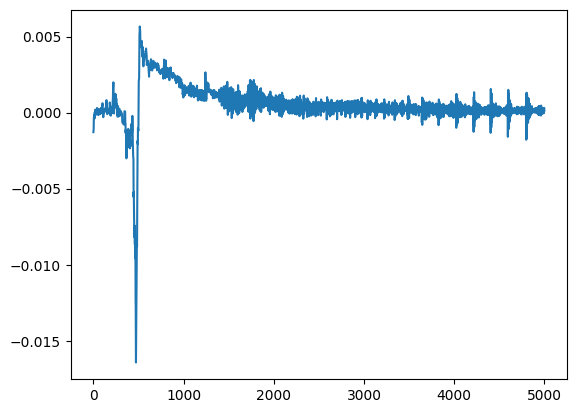

In [144]:
plt.plot(gradient_history[:,1])
plt.show()

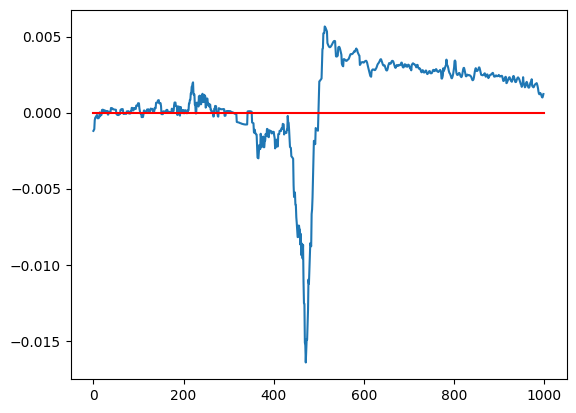

In [145]:
dat = gradient_history[1:1000,1]
plt.plot(dat)
plt.plot([0, 1000], [0, 0], 'r-')
plt.show()

This took a bit of experimentation. The following approach seems to work quite well:
* use a range of exponential weighted moving averages to accumulate the recent trend, and then pick the avg with the highest value (of the same sign) and use that to calculate the magnitude whenever the sign changes.

Note, I'd also like to measure the variances and add about 2.5x SD to the means when identifying the magnitude of error. As that will give a more accurate measure of the magnitude of gradient oscillation. However, I haven't yet figured out the right scaling rule to calculate the variances.

In [146]:
a = np.array([[1,2,3,4,5],[1,2,3,4,5]])
b = np.array([1,2]).reshape(2,1)
a * b

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10]])

In [147]:
def accumulate_exp_averages(dat):
  """
  dat: 1D vector or 2D tensor (t=time,f=features) with first dimension reflecting time in some way (eg: iterations, epochs)
  Returns:
    tuple (means, variances), with each item having shape (t,f,b), where b = number of betas
  """

  # WARNING
  # The variances calculation isn't working yet. The problem is that they
  # get scaled to very small values (circa 1x10-6).
  # For high-frequency moving average (small betas), the mean is already
  # very close to the current value, so the diff is small.
  # For low-frequnecy moving average (betas ~= 1), the averaging
  # effect reduces the scale of the error.
  # Apart from the scale problem, the values are actually quite
  # representative of what I want to capture.
  # So I just need to figure out a reliable scaling rule.

  # Identify a range of betas that provide a power-of-2 sampling
  # of different equivalent window sizes, up to 1/5-th of the total length
  # of the data
  # rule: 1/(1-beta) ~= width of equivalent sliding window
  # =>    beta = 1 - 1/w
  max_window_base = math.floor(math.log2(dat.shape[0]/5))
  window_size_bases = np.arange(1, max_window_base+1);
  window_sizes = 2**window_size_bases
  betas = 1 - 1/window_sizes
  print(f"window_sizes: {window_sizes}")
  print(f"betas: {betas}")

  # if dat is a 1D vector, then turn into 2D
  dat = dat.reshape((dat.shape[0], -1))

  n  = dat.shape[0] # number of time steps
  fs = dat.shape[1] # number of input features
  bs = len(betas)   # number of output features

  # calculate exponential weighted moving means and variances
  out_means = []
  out_variances = []

  means = np.ones(shape=(fs, bs)) * dat[0,:].reshape((fs, 1))
  variances = np.zeros(shape=(fs, bs))
  assert means.shape == (fs, bs)
  assert variances.shape == (fs, bs)

  for i, x in enumerate(dat):
    assert x.shape == (fs,)
    x = x.reshape(fs, 1)

    means = betas * means + (1-betas) * x
    assert means.shape == (fs, bs)

    variance = (means - x)**2
    assert variance.shape == (fs, bs)

    variances = betas * variances + (1-betas) * variance
    out_means.append(means)
    out_variances.append(variances)

  a = np.array(out_means)
  b = np.array(out_variances)
  assert a.shape == (n, fs, bs)
  assert b.shape == (n, fs, bs)
  return a, b

#means,variances = accumulate_exp_averages(dat)
means,variances = accumulate_exp_averages(gradient_history[1:1000,0:2])
means.shape

window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]


(999, 2, 7)

window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]
means: (999, 5, 7)


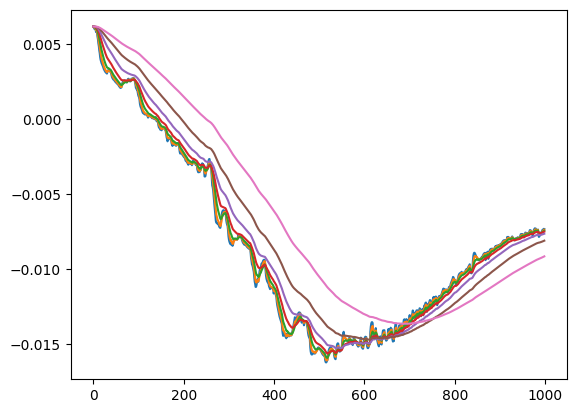

In [148]:
means,variances = accumulate_exp_averages(gradient_history[1:1000,0:5])
print(f"means: {means.shape}")
#plt.plot(dat)
plt.plot(means[:,4,:])
#plt.plot(variances.reshape((dat.shape[0], -1)))
plt.show()

window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]


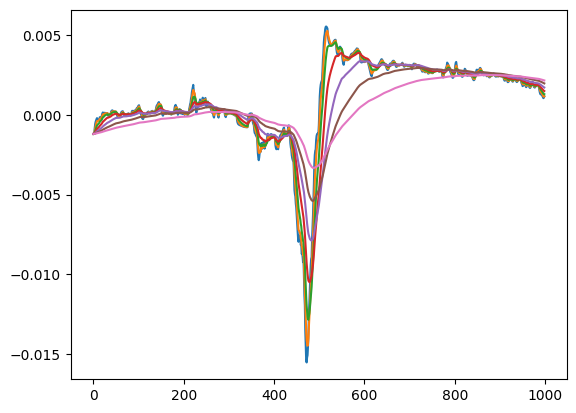

In [149]:
means,variances = accumulate_exp_averages(dat)
#plt.plot(dat)
plt.plot(means.reshape((dat.shape[0], -1)))
#plt.plot(variances.reshape((dat.shape[0], -1)))
plt.show()

In [150]:
def sign_change_magnitudes_smooth(dat):
  """
  dat: 1D vector or 2D tensor (t=time,f=features) with first dimension reflecting time in some way (eg: iterations, epochs)
  Returns:
    np.array (t,f) with each value indicating the magnitude of sign change
  """
  means, _ = accumulate_exp_averages(dat)

  # if dat is a 1D vector, then turn into 2D
  dat = dat.reshape((dat.shape[0], -1))

  n  = dat.shape[0] # number of time steps
  fs = dat.shape[1] # number of input features
  bs = means.shape[2] # number of betas

  assert means.shape == (n, fs, bs), means.shape

  out = []
  prev = dat[0,:]
  for i, x in enumerate(dat):
    assert x.shape == (fs,), x.shape

    select = np.sign(x) != np.sign(prev)
    assert select.shape == (fs,), select.shape

    maxs = np.max(means[i], axis=1)
    mins = np.min(means[i], axis=1)
    assert maxs.shape == (fs,), maxs.shape
    assert mins.shape == (fs,), mins.shape

    abs_max = np.max([np.abs(maxs), np.abs(mins)], axis=0)
    assert abs_max.shape == (fs,), abs_max.shape

    #print(x[select and x == 0].shape)
    #print(abs_max[select and x == 0].shape)

    mag = np.zeros_like(x)
    mag[select * x == 0] = abs_max[select * x == 0]
    mag[select * x > 0] = maxs[select * x > 0]
    mag[select * x < 0] = mins[select * x < 0]
    out.append(mag)
    prev = x

  return np.array(out)

events = sign_change_magnitudes_smooth(dat)

window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]


window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]
window_sizes: [  2   4   8  16  32  64 128]
betas: [0.5       0.75      0.875     0.9375    0.96875   0.984375  0.9921875]


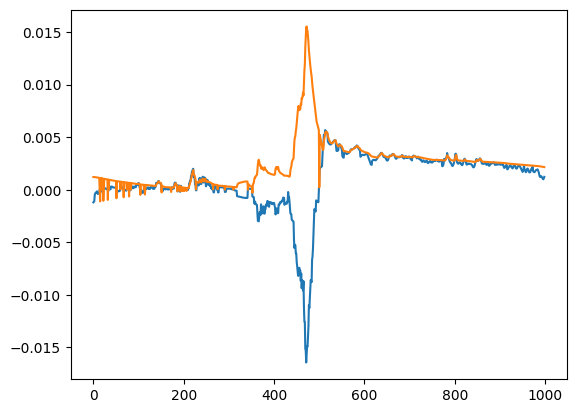

In [151]:
avgs = accumulate_exp_averages(dat)
events = sign_change_magnitudes_smooth(dat)
plt.plot(dat)
#plt.plot(avgs)
plt.plot(events)
plt.show()

In [152]:
a = np.array([[1,2,3,4], [1,2,3,4]])
b = -a
a[np.all(a % 2 ==0, a > 2)]# = b[a % 2 ==0 and a > 2]
#a

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
a[(a % 2 == 0) * (a > 2)]

In [ ]:
dat2 = gradient_history[:,0:5]
avgs = accumulate_exp_averages(dat2)
events = sign_change_magnitudes_smooth(dat2)
plt.plot(dat2)
#plt.plot(avgs)
plt.plot(events)
plt.show()

Note that this is still not quite what we want. At best the magnitude recorded here is 1/2 of what we actually want. Because we really want to know the _total magnitude of oscillation_. That requires measuring peak-to-peak, and furthermore preferentially only identifying events at those peaks, but identifying peaks is extremely difficult in noisy data.

In [ ]:
a = np.array([[1,3,4], [5,6,7]])
np.take(a, [0,1], axis=0)

In [157]:
def sign_reduce(signs, axis=0):
  """
  Applies an "abs-max-like" rule against signs, for the purpose of accumulating
  signs over a sequence of data.
  Signs are assumed produced by np.sign(), which produces -1, 0, or +1.
  In a 1D sequence, the latest non-zero sign is taken as the latest.
  In a 2D sequence, the latest non-zero sign along the given axis is taken as the latest.

  Args
    signs: (n,) or (n,...) array or array-like
    axis: Axis to perform accumulation over. Default=0
  Returns
    np.array containing reduced signs
  """
  signs = np.asarray(signs)
  shape = signs.shape
  n = shape[axis]

  slice = np.take(signs, 0, axis)
  reduced = np.zeros_like(slice)
  for i in range(n):
    slice = np.take(signs, i, axis)
    reduced = np.where(slice != 0, slice, reduced)
  return reduced

# tests
test_equals(-1, sign_reduce([-1, +1, 0, -1, 0]))
test_equals(+1, sign_reduce([0, +1, -1, 0, +1]))
test_equals(+1, sign_reduce([0, +1, 0]))
test_equals(0, sign_reduce([0, 0]))

test_equals([+1, -1], sign_reduce([[-1, 0],[+1, -1]], axis=0))
test_equals([0, +1], sign_reduce([[0, 0],[0, +1]], axis=0))
test_equals([0, 0], sign_reduce([[0, 0],[0, 0]], axis=0))

test_equals([-1, -1], sign_reduce([[-1, 0],[+1, -1]], axis=1))
test_equals([0, +1], sign_reduce([[0, 0],[0, +1]], axis=1))
test_equals([0, 0], sign_reduce([[0, 0],[0, 0]], axis=1))

In [200]:
def sign_change_magnitudes_events(dat):
  """
  dat: 1D vector or 2D tensor (t=time,f=features) with first dimension reflecting time in some way (eg: iterations, epochs)
  Returns:
    np.array (t,f) with each value indicating the magnitude of sign change
  """
  # if dat is a 1D vector, then turn into 2D
  dat = dat.reshape((dat.shape[0], -1))

  n  = dat.shape[0] # number of time steps
  fs = dat.shape[1] # number of input features

  # all "accum_..." are interpreted as tracking up-to-but-excluding the current x
  # (also note that due to the way that we manipulate these, a single instance is
  #  used throughout as a variable that changes over time)
  # ..0 = current block
  # ..1 = previous block
  accum_sign0 = np.zeros_like(dat[0,:])
  accum_peak0 = np.zeros_like(dat[0,:])
  accum_peak_point0 = np.zeros_like(dat[0,:], dtype=int)
  accum_change_point0 = np.zeros_like(dat[0,:], dtype=int)

  accum_sign1 = np.zeros_like(dat[0,:])
  accum_peak1 = np.zeros_like(dat[0,:])
  accum_peak_point1 = np.zeros_like(dat[0,:], dtype=int)
  accum_change_point1 = np.zeros_like(dat[0,:], dtype=int)

  # pre-allocate for reuse when gathering from
  zeros = np.zeros_like(dat[0,:])

  out = []
  out_flips = []
  out_accum_sign0 = []
  out_accum_peak0 = []
  out_accum_peak_point0 = []
  out_accum_change_point0 = []
  out_accum_sign1 = []
  out_accum_peak1 = []
  out_accum_peak_point1 = []
  out_accum_change_point1 = []

  for i, x in enumerate(dat):
    assert x.shape == (fs,), x.shape

    # identify sign flips
    sign = sign_reduce([accum_sign0, np.sign(x)], axis=0)  # sorts out the zeros, so almost always only +1 or -1
    flips = (accum_sign0 * sign) < 0           # only flips once x becomes +1 or -1, not when it just touches 0
    assert sign.shape == (fs,), sign.shape
    assert flips.shape == (fs,), flips.shape
    assert np.all(np.sign(x)[flips] != 0)

    # rotate blocks on sign flips
    accum_sign1[flips] = accum_sign0[flips]
    accum_peak1[flips] = accum_peak0[flips]
    accum_peak_point1[flips] = accum_peak_point0[flips]
    accum_change_point1[flips] = accum_change_point0[flips]

    # start new block on sign flips
    assert accum_sign0.shape == (fs,), accum_sign0.shape
    assert sign.shape == (fs,), sign.shape
    assert accum_sign0[flips].shape == sign[flips].shape, accum_sign0[flips].shape
    accum_sign0[flips] = sign[flips]
    accum_peak0[flips] = zeros[flips]
    accum_peak_point0[flips] = i  # starts at begining of block, but moves forward each new peak point found
    accum_change_point0[flips] = i

    # accumulate against current block
    accum_sign0 = sign
    accum_peak_point0[sign >= 0] = np.where(accum_peak0 > x, i, accum_peak_point0)[sign >= 0]
    accum_peak_point0[sign < 0]  = np.where(accum_peak0 < x, i, accum_peak_point0)[sign < 0]
    accum_peak0[sign >= 0] = np.max([accum_peak0, x], axis=0)[sign >= 0]
    accum_peak0[sign < 0]  = np.min([accum_peak0, x], axis=0)[sign < 0]
    assert accum_sign0.shape == (fs,), accum_sign0.shape
    assert accum_peak0.shape == (fs,), accum_peak0.shape
    assert accum_peak_point0.shape == (fs,), accum_peak_point0.shape

    # track magnitudes but store against change points
    out.append(np.zeros_like(x))
    mag = accum_peak0 - accum_peak1 # TODO wrap in np.abs(...)
    for j, i2 in enumerate(accum_change_point0):
      assert np.shape(out[i2][j]) == (), np.shape(out[i2][j])
      assert np.shape(mag[j]) == (), np.shape(mag[j])
      out[i2][j] = mag[j]

    out_flips.append(flips)
    out_accum_sign0.append(accum_sign0.copy())
    out_accum_peak0.append(accum_peak0.copy())
    out_accum_peak_point0.append(accum_peak_point0.copy())
    out_accum_change_point0.append(accum_change_point0.copy())
    out_accum_sign1.append(accum_sign1.copy())
    out_accum_peak1.append(accum_peak1.copy())
    out_accum_peak_point1.append(accum_peak_point1.copy())
    out_accum_change_point1.append(accum_change_point1.copy())

  return (np.array(out),
    {
        'flips': np.array(out_flips),
        'sign0': np.array(out_accum_sign0),
        'peak0': np.array(out_accum_peak0),
        'peak_at0': np.array(out_accum_peak_point0),
        'change_at0': np.array(out_accum_change_point0),
        'sign1': np.array(out_accum_sign1),
        'peak1': np.array(out_accum_peak1),
        'peak_at1': np.array(out_accum_peak_point1),
        'change_at1': np.array(out_accum_change_point1)
    })

  # todo change sign_max so that it resolves ambiguities by taking the latest values along the axis

events, info = sign_change_magnitudes_events(dat)

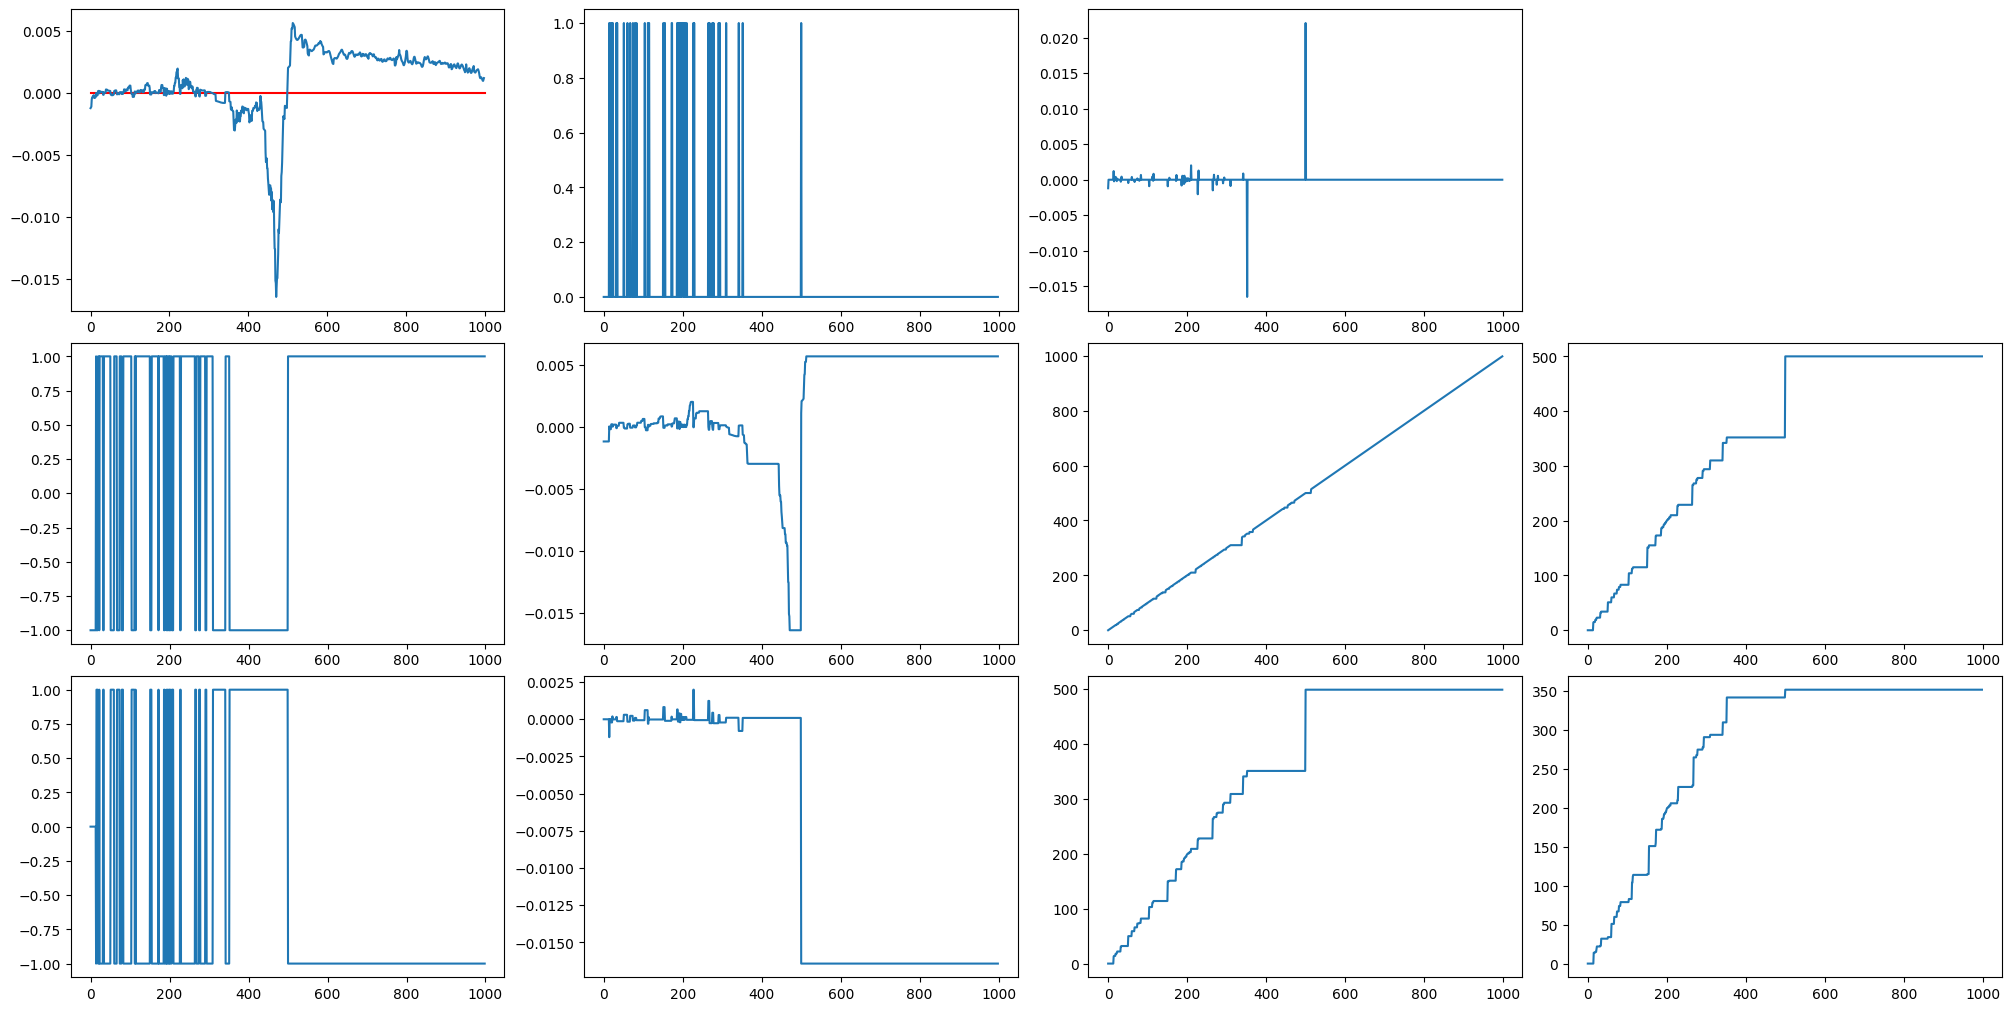

In [201]:
plt.figure(figsize=(20,10), layout='constrained')
plt.subplot(3,4,1)
plt.plot([0, 1000], [0, 0], 'r-')
plt.plot(dat)
plt.subplot(3,4,2)
plt.plot(info['flips'])
plt.subplot(3,4,3)
plt.plot(events)

plt.subplot(3,4,5)
plt.plot(info['sign0'])
plt.subplot(3,4,6)
plt.plot(info['peak0'])
plt.subplot(3,4,7)
plt.plot(info['peak_at0'])
plt.subplot(3,4,8)
plt.plot(info['change_at0'])

plt.subplot(3,4,9)
plt.plot(info['sign1'])
plt.subplot(3,4,10)
plt.plot(info['peak1'])
plt.subplot(3,4,11)
plt.plot(info['peak_at1'])
plt.subplot(3,4,12)
plt.plot(info['change_at1'])

plt.show()